# Analysis of genes which are specific to ASD and CHD 

For supplemental figure 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')

import sys

import adjustText

% matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Load ASD, CHD genesets

ASD HC genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [3]:
# ------- ASD HC genes -------

ASD_HC = pd.read_csv('../../data/ASD_HC.txt',names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
len(ASD_HC)



65

In [4]:
# ------- High confidence CHD genes -------

# Load congenital heart defect recurring DNVs (from http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)

CHD_seed_type='CHD_full' # can be 'CHD_withNDD', 'CHD_full', or 'CHD_only'

if CHD_seed_type=='CHD_full':
    # new HC genes:
    CHD_HC = pd.read_csv('../../data/CHD_HC_new.txt',names=['HC_genes'])
elif CHD_seed_type=='CHD_withNDD':
    CHD_HC = pd.read_csv('../../data/CHD_withNDD_HC_new.txt',names=['HC_genes'])
elif CHD_seed_type=='CHD_only':
    CHD_HC = pd.read_csv('../../data/CHD_only_HC_new.txt',names=['HC_genes'])

CHD_HC = CHD_HC['HC_genes'].tolist()
len(CHD_HC)


66

In [5]:
# Load all CHD DNVs (from 2017 paper)

CHD_DNV_df = pd.read_excel('../../data/CHD_databases_2017_paper/ng.3970-S3.xlsx',sheetname='S9',skiprows=1)
CHD_DNV_df.index=CHD_DNV_df['Blinded ID']

# exclude patients which have variants in HC genes -- from Trey's comment April 2019
# print(len(CHD_DNV_df))
# CHD_DNV_df = CHD_DNV_df[~CHD_DNV_df['Gene'].isin(ASD_HC+CHD_HC)]
# print(len(CHD_DNV_df))

# apply the same filtering as for old data
CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant_Class']!='syn')*(CHD_DNV_df['Variant_Class']!='mis')]
print('number damaging CHD DNVs:')
print(len(CHD_DNV))

CHD_DNV_VC = CHD_DNV['Gene'].value_counts() # count recurrences-- should be 0 because we removed them
print('\nnumber recurrent damaging CHD DNVs:')
print(sum(CHD_DNV_VC>1))

DNV_withNDD_full = CHD_DNV[CHD_DNV['NDD']=='Yes']
print('\nnumber damaging CHD DNVs with NDD:')
print(len(DNV_withNDD_full)) # number of patients
DNV_withNDD_full = DNV_withNDD_full['Gene'].unique().tolist()
print('\nnumber damaging unique CHD DNVs with NDD:')
print(len(DNV_withNDD_full)) # number of genes

DNV_noNDD_full = CHD_DNV[CHD_DNV['NDD']=='No']
DNV_noNDD_full = DNV_noNDD_full['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs without NDD:')
print(len(DNV_noNDD_full))


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


number damaging CHD DNVs:
827

number recurrent damaging CHD DNVs:
66

number damaging CHD DNVs with NDD:
226

number damaging unique CHD DNVs with NDD:
198

number damaging CHD DNVs without NDD:
309


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Use all SSC patients, most will not have heart phenos

Unsure of how reliable heart phenotyping is

In [6]:
# load the SSC data DNV data (homsy et al S08)
SSC_DNV = pd.read_excel('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/data/CHD_NDD_databases/homsy_database_S08.xlsx',
                       skiprows=1)
# Variant classes have already been filtered to be damaging

# filter by study == SSC
print(len(SSC_DNV))
SSC_DNV = SSC_DNV[SSC_DNV['Study']=='SSC']
print(len(SSC_DNV))
SSC_DNV.index=SSC_DNV['Proband ID']

# filter by Probands in ASD_heart_no
# was dropping NA columns, which was overly restrictive
# SSC_DNV_heart_no = SSC_DNV #SSC_DNV.loc[ASD_heart.index].dropna()
# print(len(SSC_DNV_heart_no))
# SSC_DNV_heart_no.head()



1563
750


In [7]:
SSC_DNV.index=SSC_DNV['Gene']
SSC_DNV.head()

print(SSC_DNV.loc['CAPN12'])

# put the index back
SSC_DNV.index=SSC_DNV['Proband ID']

Study                                    SSC
CHR                                       19
POS                                 39228219
REF                                        G
ALT                                        A
Proband ID                          14369.p1
Class                               missense
Class (2)                              D-mis
Gene                                  CAPN12
Ensembl Gene ID              ENSG00000182472
AA1                                        P
AA2                                        L
dbNSFP Meta-SVM Rankscore            0.92379
Name: CAPN12, dtype: object


In [8]:
SSC_DNV_genes = SSC_DNV['Gene'].unique().tolist()
print(len(SSC_DNV_genes))

663


In [9]:
SSC_DNV_all_genes = SSC_DNV['Gene'].unique().tolist()
print(len(SSC_DNV_all_genes))

663


In [10]:
# pick out which gene sets to investigate
genes_ASD = ASD_HC
print(len(genes_ASD))
genes_CHD = CHD_HC
print(len(genes_CHD))

65
66


# Load previously computed z-scores, and define and load interactome

In [11]:
# load previously computed z-scores and focal interactome
import scipy

num_reps = 5000
focal_interactome='PCnet'
rand_method = 'degree_binning' # can be 'degree_binning' or 'degree_ks_test'

z_ASD = pd.read_csv('../z_score_results/new_CHD_cohort/z_ASD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                sep='\t',names=['gene','zscore'],index_col='gene')
if CHD_seed_type=='CHD_full':
    z_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_CHD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')
elif CHD_seed_type=='CHD_withNDD':
    z_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_CHD_withNDD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')
elif CHD_seed_type=='CHD_only':
    z_CHD = pd.read_csv('../z_score_results/new_CHD_cohort/z_CHD_only_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')

z_ASD = z_ASD['zscore'].copy()
z_CHD = z_CHD['zscore'].copy()
     

    

# merge z_ASD, z_CHD, SSC_DNV_heart_no_genes, and DNV_noNDD_full

In [12]:
z_merged = pd.DataFrame(z_ASD).join(pd.DataFrame(z_CHD),lsuffix='_ASD',rsuffix='_CHD')
SSC_DNV_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
SSC_DNV_temp.loc[np.intersect1d(SSC_DNV_genes,z_merged.index.tolist())]=1
z_merged['SSC_DNV']=SSC_DNV_temp

SSC_DNV_all_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
SSC_DNV_all_temp.loc[np.intersect1d(SSC_DNV_all_genes,z_merged.index.tolist())]=1
z_merged['SSC_DNV_all']=SSC_DNV_all_temp

DNV_noNDD_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
DNV_noNDD_temp.loc[np.intersect1d(DNV_noNDD_full,z_merged.index.tolist())]=1
z_merged['CHD_DNV_noNDD']=DNV_noNDD_temp

DNV_withNDD_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
DNV_withNDD_temp.loc[np.intersect1d(DNV_withNDD_full,z_merged.index.tolist())]=1
z_merged['CHD_DNV_withNDD']=DNV_withNDD_temp

# add columns for seeds
ASD_seeds_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
ASD_seeds_temp.loc[ASD_HC]=1

CHD_seeds_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
CHD_seeds_temp.loc[CHD_HC]=1

z_merged['ASD_seeds']=ASD_seeds_temp
z_merged['CHD_seeds']=CHD_seeds_temp

z_merged.head()

,zscore_ASD,zscore_CHD,SSC_DNV,SSC_DNV_all,CHD_DNV_noNDD,CHD_DNV_withNDD,ASD_seeds,CHD_seeds
gene,,,,,,,,
UBE2Q1,2.916925,-1.684994,0.0,0.0,0.0,0.0,0.0,0.0
DUOXA1,-1.246714,2.746811,0.0,0.0,0.0,0.0,0.0,0.0
UBE2Q2,-0.110783,-1.145172,0.0,0.0,0.0,0.0,0.0,0.0
RNF10,-0.845825,0.021980,0.0,0.0,0.0,0.0,0.0,0.0
RNF11,1.197470,-0.553832,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# z_merged.to_csv('../../manuscript/tables_19_01/ASD_CHD_specific_genes.tsv',sep='\t')

In [17]:
print(len(SSC_DNV_genes))
print(len(np.intersect1d(SSC_DNV_genes,z_merged.index.tolist())))

663
654


# load the focal interactome

In [18]:
# used to have more options, now just focus on PCnet

if focal_interactome=='PCnet':
    Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
    
print(len(Gint.edges()))
print(len(Gint.nodes()))

2724724
19781


# How do CHD no NDD DNVs rank in z score lists?

2
269
324
19652
ASD enrichment = 0.8232697053664979
9
269
206
19652
CHD enrichment = 0.0005672963488573282


Text(0,0.5,'number recovered non-NDD CHD DNVs')

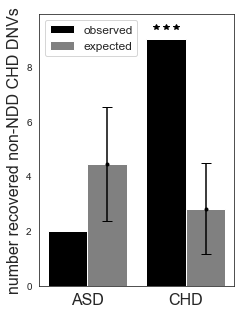

In [19]:
z_thresh = 3

# ---------------------------------------------------------------------------
# ----------- single ASD z-scores -----------

# filter by high ASD score
z_ASD_g1 = z_ASD[(z_ASD>z_thresh)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC)) # don't include seeds

# filter by low CHD score too
z_ASD_g1 = list(np.intersect1d(z_ASD_g1,z_CHD[z_CHD<2].index.tolist()))


DNV_in_graph = list(np.intersect1d(DNV_noNDD_full,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,ASD_HC+CHD_HC))

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC+CHD_HC)))

M = len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC+CHD_HC))
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(ASD_p))

# calculate expected mean and std given M,n,N
exp_ASD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_ASD_std = scipy.stats.hypergeom.std(M,n,N)


# ---------------------------------------------------------------------------
# ------------------- single CHD z-scores -------------------
z_CHD_g1 = z_CHD[(z_CHD>z_thresh)].index.tolist()

# filter by low ASD score as well
z_CHD_g1 = list(np.intersect1d(z_CHD_g1,z_ASD[z_ASD<2].index.tolist()))

z_CHD_g1 = list(np.setdiff1d(z_CHD_g1,CHD_HC)) # don't include seeds

DNV_in_graph = list(np.intersect1d(DNV_noNDD_full,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,CHD_HC+ASD_HC))


CHD_g1 = np.intersect1d(DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(DNV_noseeds))
print(len(z_CHD_g1))
print(len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC+ASD_HC)))

M = len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC+ASD_HC))
n=len(DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(CHD_p))

# calculate expected mean and std given M,n,N
exp_CHD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_CHD_std = scipy.stats.hypergeom.std(M,n,N)
    
# -------------------------------------------
# plot the results
plt.figure(figsize=(3.5,5))

recovered_list = [len(ASD_g1),len(CHD_g1)]
pval_list = [ASD_p,CHD_p]

plt.bar([0,1],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],
             [exp_ASD_std,exp_CHD_std],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                

plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2],['ASD','CHD'],fontsize=16)
plt.ylabel('number recovered non-NDD CHD DNVs',fontsize=16)


# plt.savefig('../../manuscript/figures_1911/'+focal_interactome+'/z_score_num_recovered_DNVs_CHDonly_'+str(z_thresh)+'.png',
#            dpi=300,bbox_inches='tight')

# Make the same ASD-CHD density figure, but this time show the CHD-only NDDs

In [20]:

combine_after_zscore=True
include_seeds=False # plot with or without seeds

z_ASD_abs = z_ASD.copy(deep=True)
ASD_HC_in_G = list(np.intersect1d(ASD_HC,Gint.nodes()))


z_CHD_abs = z_CHD.copy(deep=True)
CHD_HC_in_G = list(np.intersect1d(CHD_HC,Gint.nodes()))



if include_seeds==False: # remove seeds if false
    z_ASD_abs.loc[ASD_HC_in_G]=np.nan # remove the seeds
    z_CHD_abs.loc[CHD_HC_in_G]=np.nan # remove the seeds



-4.34949947011
-4.70643282787


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:57: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


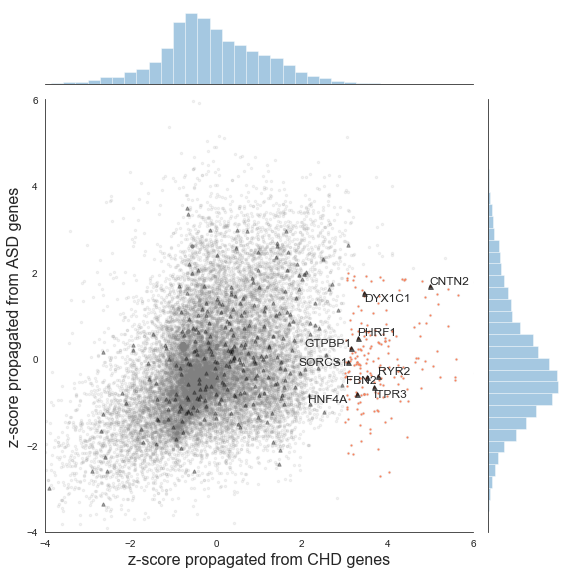

In [40]:

# -------------------- Plot on the paired disorder axes ----------------------

print(z_ASD.min())
print(z_CHD.min())
D1name='ASD'
D2name='CHD'

genes_D1 = ASD_HC
genes_D2 = CHD_HC

idx_temp = z_CHD_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]
# j = sns.jointplot(z_CHD_abs,z_ASD_abs,gridsize=50,kind='hex',size=10)
j = sns.jointplot(z_CHD_abs,z_ASD_abs,kind='scatter',height=8,alpha=.1,joint_kws={'s':6,'color':'gray'})
plt.sca(j.ax_joint)

plt.xlabel('z-score propagated from '+D2name+' genes',fontsize=16)
plt.ylabel('z-score propagated from '+D1name+' genes', fontsize=16)

zthresh=3

if combine_after_zscore == True:
    z_score_both = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_CHD 

high_CHD_genes = z_CHD[z_CHD>zthresh].index.tolist()
high_CHD_genes = list(np.intersect1d(high_CHD_genes,z_CHD[z_ASD<2.0].index.tolist()))
plt.plot((z_CHD_abs.loc[high_CHD_genes]),(z_ASD_abs.loc[high_CHD_genes]),'.',color='#F9825C',
         ms=2,alpha=1)

only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>zthresh].index.tolist()))

plt.plot((z_CHD_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=4.5,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')

# overlay the DNVs with NDDs
plt.plot(z_CHD_abs.loc[DNV_noNDD_full],z_ASD_abs.loc[DNV_noNDD_full],'k^',ms=3.5,alpha=.3)

#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = list(np.intersect1d(high_ASD_genes,SSC_DNV_genes)) #((z_ASD_abs.loc[DNV_noNDD_full]+10)*(z_CHD_abs.loc[DNV_noNDD_full]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
DNVs_top_10 = z_CHD_abs.loc[DNVs_top_10].dropna().index.tolist()
DNVs_top_10 = z_ASD_abs.loc[DNVs_top_10].dropna().sort_values(ascending=False).head(10).index.tolist()


#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = list(np.intersect1d(high_CHD_genes,DNV_noNDD_full)) #((z_ASD_abs.loc[DNV_noNDD_full]+10)*(z_CHD_abs.loc[DNV_noNDD_full]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
DNVs_top_10 = z_ASD_abs.loc[DNVs_top_10].dropna().index.tolist()
DNVs_top_10 = z_CHD_abs.loc[DNVs_top_10].dropna().sort_values(ascending=False).head(10).index.tolist()

# plot DNVs in relevant section bolder
plt.plot(z_CHD_abs.loc[DNVs_top_10],z_ASD_abs.loc[DNVs_top_10],'k^',ms=5,alpha=.5)

# use adjustText to make labels not overlap     
texts_tmp = [plt.text(z_CHD_abs.loc[d],z_ASD_abs.loc[d],
                         d,fontsize=12) for d in DNVs_top_10]
adjustText.adjust_text(texts_tmp,force_points=(0,0),force_objects=(0,0),expand_points=(0,0),expand_objects=(0,0),
                      lim=3)


ax=plt.gca()

if include_seeds==False: # only set ades limits if not including seeds
    plt.xlim([-4,6])
    plt.ylim([-4,6])

fname_string = '../../manuscript/figures_1911/'+focal_interactome+'/ASD_CHD_zscore_noNDD'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore.png'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore.png'
    
# plt.savefig(fname_string,dpi=300,bbox_inches='tight')

# How do ASD-only genes rank?

20
583
324
19713
ASD enrichment = 0.0006951180642097164
6
583
206
19712
CHD enrichment = 0.408838579134754


Text(0,0.5,'number recovered ASD DNVs')

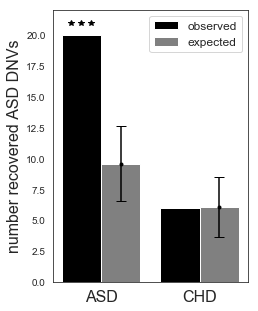

In [22]:
z_thresh = 3
# ---------------------------------------------------------------------------
# ------------------- single ASD z-scores -------------------
z_ASD_g1 = z_ASD[(z_ASD>z_thresh)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC)) # don't include seeds

# filter by low CHD score too
z_ASD_g1 = list(np.intersect1d(z_ASD_g1,z_CHD[z_CHD<2].index.tolist()))


DNV_in_graph = list(np.intersect1d(SSC_DNV_genes,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,ASD_HC+CHD_HC))

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC)))

M = len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC))
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(ASD_p))

# calculate expected mean and std given M,n,N
exp_ASD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_ASD_std = scipy.stats.hypergeom.std(M,n,N)


# ---------------------------------------------------------------------------
# ------------------- single CHD z-scores -------------------
z_CHD_g1 = z_CHD[(z_CHD>z_thresh)].index.tolist()

# filter by low ASD score as well
z_CHD_g1 = list(np.intersect1d(z_CHD_g1,z_ASD[z_ASD<2].index.tolist()))

z_CHD_g1 = list(np.setdiff1d(z_CHD_g1,CHD_HC)) # don't include seeds

DNV_in_graph = list(np.intersect1d(SSC_DNV_genes,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,CHD_HC+ASD_HC))


CHD_g1 = np.intersect1d(DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(DNV_noseeds))
print(len(z_CHD_g1))
print(len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC)))

M = len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC))
n=len(DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(CHD_p))

# calculate expected mean and std given M,n,N
exp_CHD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_CHD_std = scipy.stats.hypergeom.std(M,n,N)
    
# -------------------------------------------
# plot the results
plt.figure(figsize=(3.5,5))

recovered_list = [len(ASD_g1),len(CHD_g1)]
pval_list = [ASD_p,CHD_p]

plt.bar([0,1],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],
             [exp_ASD_std,exp_CHD_std],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                


plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2],['ASD','CHD'],fontsize=16)
plt.ylabel('number recovered ASD DNVs',fontsize=16)


# plt.savefig('../../manuscript/figures_1911/'+focal_interactome+'/z_score_num_recovered_DNVs_ASDonly_'+str(z_thresh)+'.png',
#            dpi=300,bbox_inches='tight')

-4.34949947011
-4.70643282787


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:84: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


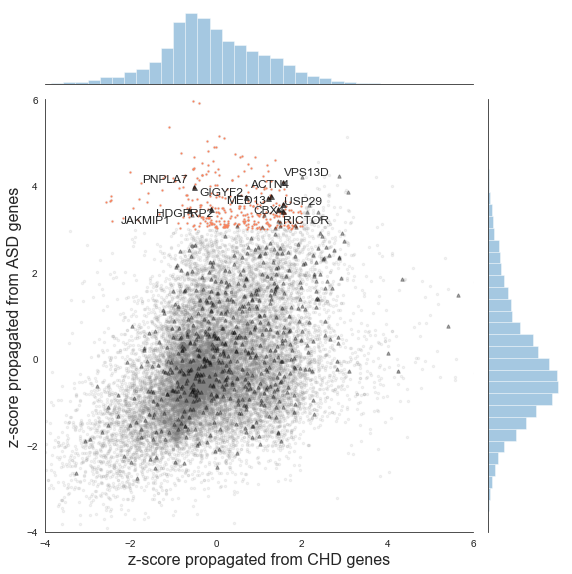

In [37]:


# -------------------- Plot on the paired disorder axes, ASD-specific ----------------------

print(z_ASD.min())
print(z_CHD.min())
D1name='ASD'
D2name='CHD'

genes_D1 = ASD_HC
genes_D2 = CHD_HC

idx_temp = z_CHD_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]

j = sns.jointplot(z_CHD_abs,z_ASD_abs,kind='scatter',height=8,alpha=.1,joint_kws={'s':6,'color':'gray'})


plt.sca(j.ax_joint)

plt.xlabel('z-score propagated from '+D2name+' genes',fontsize=16)
plt.ylabel('z-score propagated from '+D1name+' genes', fontsize=16)


zthresh=3

if combine_after_zscore == True:
    z_score_both = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_CHD 

high_ASD_genes = z_ASD[z_ASD>zthresh].index.tolist()
high_ASD_genes = list(np.intersect1d(high_ASD_genes,z_ASD[z_CHD<2.0].index.tolist()))
plt.plot((z_CHD_abs.loc[high_ASD_genes]),(z_ASD_abs.loc[high_ASD_genes]),'.',color='#F9825C',
         ms=2,alpha=1)

only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>zthresh].index.tolist()))

plt.plot((z_CHD_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=4.5,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')

# plot the DNVs
plt.plot(z_CHD_abs.loc[SSC_DNV_genes],z_ASD_abs.loc[SSC_DNV_genes],'k^',ms=3.5,alpha=.3)


#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = list(np.intersect1d(high_ASD_genes,SSC_DNV_genes)) #((z_ASD_abs.loc[DNV_noNDD_full]+10)*(z_CHD_abs.loc[DNV_noNDD_full]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
DNVs_top_10 = z_CHD_abs.loc[DNVs_top_10].dropna().index.tolist()
DNVs_top_10 = z_ASD_abs.loc[DNVs_top_10].dropna().sort_values(ascending=False).head(10).index.tolist()

# plot DNVs in relevant section bolder
plt.plot(z_CHD_abs.loc[DNVs_top_10],z_ASD_abs.loc[DNVs_top_10],'k^',ms=5,alpha=.5)

# use adjustText to make labels not overlap     
texts_tmp = [plt.text(z_CHD_abs.loc[d],z_ASD_abs.loc[d],
                         d,fontsize=12) for d in DNVs_top_10]
adjustText.adjust_text(texts_tmp,force_points=(0,0),force_objects=(0,0),expand_points=(0,0),expand_objects=(0,0),
                      lim=3)
            
ax=plt.gca()

if include_seeds==False: # only set ades limits if not including seeds
    plt.xlim([-4,6])
    plt.ylim([-4,6])

#ax.set_yscale('log')
#ax.set_xscale('log')

fname_string = '../../manuscript/figures_1911/'+focal_interactome+'/ASD_CHD_zscore_ASD_focused'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore.png'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore.png'
    
# plt.savefig(fname_string,dpi=300,bbox_inches='tight')